# Compare UNet deconv. quality varying max atmospheric FWHM
v>=26dec25

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [2]:
from model import *
from galaxy_img_utils import *

#for Wiener decon
from deconv_wiener import *

In [3]:
import pandas as pd

In [4]:
from utils_plot import *

# You can regenerate the Pandas DF or directly jump to the ploting section using the provided parquet file. 

# Use trained models on validation images

In [5]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"


with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [6]:
args

namespace(fov_pixels=48,
          pixel_scale=0.03,
          upsample=4,
          atmos_fwhm=0.4,
          atmos_e=0.01,
          sigma_defocus=0.1,
          sigma_opt_psf=0.07,
          min_shear=0.01,
          max_shear=0.05,
          opt_obs_min=0.1,
          opt_obs_width=0.4,
          lam_ov_d_min=0.017,
          lam_ov_d_width=0.007,
          sigma_noise_max=1.0,
          archi='Unet-Full',
          pool_window=2,
          num_blocks=2,
          num_kernels=64,
          num_channels=1,
          kernel_size=3,
          padding=1,
          bias=True,
          num_enc_conv=2,
          num_mid_conv=2,
          num_dec_conv=2,
          input_cosmos_dir='/lustre/fsn1/projects/rech/ixh/ufd72rp/',
          input_data_dir='../',
          input_gal_file_list='list_gal_files_48pix.json',
          models_root_dir='../models/',
          seed=116122025,
          num_workers=10,
          checkpoint_file='/Unet-Full_last_state.pth',
          history_loss_cpt_file=

In [7]:
args.atmos_fwhm = 0.8 #for this notebook

In [8]:
# device cpu/gpu...
args.device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

In [9]:
if args.input_gal_file_list is not None:
    # in case the original COSMOS files have been filtered (eg. minimum pixel size required)
    fname = args.input_data_dir + args.input_gal_file_list
    try:
        with open(fname, "r") as f:
            info = json.load(f)
            all_gal = info["all_gal"]
            all_psf = info["all_psf"]
            all_noise = info["all_noise"]
            all_info = info["all_info"]
    except FileNotFoundError:
        print(f"The file {fname} was not found: look for location.")
    except IOError:
        print(f"An error occurred while reading the file {fname}.")
else:
    print("input_gal_file_list not set...")

In [10]:
# Update the data location
all_gal   = [args.input_cosmos_dir + x for x in all_gal]
all_psf   = [args.input_cosmos_dir + x for x in all_psf]
all_noise = [args.input_cosmos_dir + x for x in all_noise]
all_info  = [args.input_cosmos_dir + x for x in all_info]

In [11]:
n_total = len(all_gal)
print(n_total)
assert n_total == len(all_psf), "pb n_total neq n_psf"
assert n_total == len(all_noise), "pb n_total neq n_noise"
assert n_total == len(all_info), "pb n_total neq n_info"

53923


In [12]:
sequence = np.arange(0, n_total)
# sequence of validation images not seen by any models during their training
val_seq = sequence[-args.n_val:]  

In [13]:
ds_val  = GalaxyDataset(args,
                             all_gal,
                             all_psf,
                             all_noise,
                             all_info,
                             val_seq,
                           debug=True)


val_loader = DataLoader(
        dataset=ds_val,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=1,
        drop_last=True,
)

GalaxyDataset: size 1000  among  53923 galaxies


## load models

In [14]:
def load_Unet(model_dir):
    model_checkpoint_file = model_dir + "Unet-Full_best_state.pth"
    model = UNet(args)
    model.to(args.device);
    checkpoint = torch.load(model_checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [15]:
models = {}

In [17]:
models_dict = {
    "dir": ["Unet_cosmo_atm0d05_sigma1d0_40000train_64kernels_2blocks_MSE",
            "Unet_cosmo_atm0d2_sigma1d0_40000train_64kernels_2blocks_MSE",
            "Unet_cosmo_atm0d4_sigma1d0_40000train_64kernels_2blocks_MSE",
            "Unet_cosmo_atm0d6_sigma1d0_40000train_64kernels_2blocks_MSE",
            "Unet_cosmo_atm0d8_sigma1d0_40000train_64kernels_2blocks_MSE"],
    "fwhm_max":[0.05, 0.20,0.40, 0.60, 0.80]
            }

In [18]:
# single mdoel Unet ("u")
df1 = pd.DataFrame(columns=["fwhm_max", "psnr_in", "psnr_u"])

In [22]:
def init_dataframe(args, models_dict):
    for i,fwhm_max in enumerate(models_dict['fwhm_max']):
        df1.loc[i] = {"fwhm_max": fwhm_max, "psnr_in":[], "psnr_u":[]}
        model_dir = args.models_root_dir + '/' + models_dict["dir"][i] + '/'
        models[fwhm_max]=load_Unet(model_dir)

In [23]:
init_dataframe(args,models_dict)

In [24]:
df1

,fwhm_max,psnr_in,psnr_u
0,0.05,[],[]
1,0.20,[],[]
2,0.40,[],[]
3,0.60,[],[]
4,0.80,[],[]


In [25]:
models.keys()

dict_keys([0.05, 0.2, 0.4, 0.6, 0.8])

## Analysis: Loop over validation images

In [26]:
args.atmos_fwhm = 0.8 # maximum atmospheric Kolmogorov fwhm for generating observed image 

In [49]:
# init randoms
reset_randoms(args)


# typical timing: 700 sec for 1000 validation images
for i_batch, imgs in enumerate(val_loader):
    gt, obs, gt_full, conv, psf_obs, sigma = imgs

    if i_batch%100 == 0 or i_batch == 0:
            print("start i_batch:",i_batch)
    #for debug
    #if i_batch>100: 
    #    break
    
    gt = gt.to(args.device)
    obs = obs.to(args.device)
    for fwhm_max in models.keys():
        # save in df1
        index_ligne = df1[(df1["fwhm_max"] == fwhm_max)].index
        if index_ligne.empty:
            print(f"No line in df1 for fwhm_max={fwhm_max}")
            break
        #Unet deconv
        with torch.no_grad():
            output = models[fwhm_max](obs)
    
        gt_img = gt.cpu().numpy().squeeze()
        obs_img = obs.cpu().numpy().squeeze()
        gt_full_img = gt_full.cpu().numpy().squeeze()
        conv_img = conv.cpu().squeeze()
        psf_obs_img = psf_obs.cpu().numpy().squeeze()
        unet_deconv_img = output.cpu().numpy().squeeze()
    
            
        #PSNR
        psnr_in = psnr(obs_img,gt_img)
        df1.at[index_ligne[0], "psnr_in"].append(psnr_in)
        psnr_unet = psnr(unet_deconv_img,gt_img)
        df1.at[index_ligne[0], "psnr_u"].append(psnr_unet)    

start i_batch: 0
start i_batch: 100
start i_batch: 200
start i_batch: 300
start i_batch: 400
start i_batch: 500
start i_batch: 600
start i_batch: 700
start i_batch: 800
start i_batch: 900


In [50]:
df1.to_parquet("single_Unet_sigmamax1d0_fwhmmax.parquet")

In [51]:
i_batch

999

# Ploting results (post analysis)

## load dataframes filled during analysis

In [27]:
df1 = pd.read_parquet("single_Unet_sigmamax1d0_fwhmmax.parquet")
fwhm_max_for_gen = 0.8

In [28]:
fwhm_list = df1["fwhm_max"].tolist()

In [29]:
fwhm_list

[0.05, 0.2, 0.4, 0.6, 0.8]

In [30]:
couleurs_temperature = [
    "#B3DFFF",  # Bleu glacier (froid)
    "#1A75FF",  # Bleu moyen
    "#33CC33",  # Vert foncé (tempéré)
    "#FF9933",  # Orange soutenu
    "#FF3333"   # Rouge foncé
]

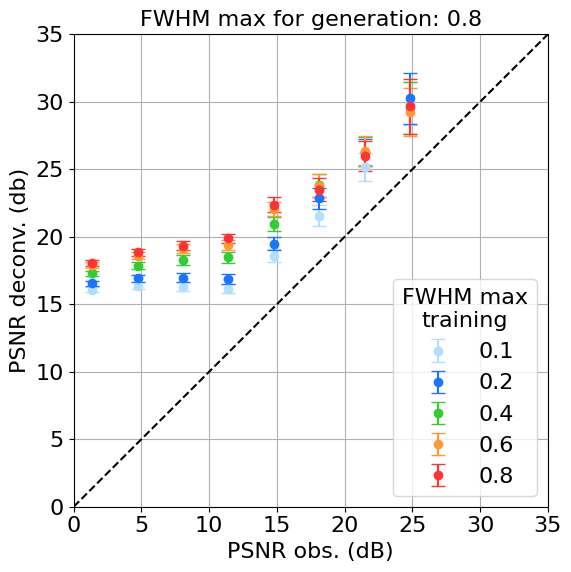

In [31]:
from matplotlib.font_manager import FontProperties

fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,fwhm_max in enumerate(fwhm_list):

    line = df1.loc[df1["fwhm_max"] == fwhm_max]
    psnr_in = line["psnr_in"].iloc[0] 
    psnr_unet = line["psnr_u"].iloc[0] 
    hbprof(psnr_in, psnr_unet, n_bins=10, error_type='sem', ax=ax, label=f'{fwhm_max:.1f}', 
           color=couleurs_temperature[i])


mynewline = lines.Line2D((0,35),(0,35),
                         color='k',linestyle="--")
ax.add_line(mynewline)
ax.grid()
ax.set_xlim([0,35])
ax.set_ylim([0,35]);
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))

#legend=ax.legend(title="FWHM max\ntraining", loc='lower right',
#          bbox_to_anchor=(1.2, 1.0))
legend=ax.legend(title="FWHM max\ntraining", loc='lower right')
title = legend.get_title()
title.set_ha('center')
ax.set_ylabel("PSNR deconv. (db)")
ax.set_xlabel("PSNR obs. (dB)");
ax.set_title(f"FWHM max for generation: {fwhm_max_for_gen}");
plt.tight_layout()
###fig.savefig("PSNR_Unet_deconv_vs_obs_FWHM_MAX.pdf");